# Demo MODIS seasonal snow masking over Mt. Rainier, WA

Based partially on

Wrzesien, M. L., Pavelsky, T. M., Durand, M. T., Dozier, J., & Lundquist, J. D. (2019). Characterizing biases in mountain snow accumulation from global data sets. Water Resources Research, 55, 9873–9891. https://doi.org/10.1029/2019WR025350

In [1]:
!pip install -q easysnowdata

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prefect 2.16.4 requires python-multipart>=0.0.7, which is not installed.
prefect 2.16.4 requires importlib-resources<6.2.0,>=6.1.3, but you have importlib-resources 6.3.2 which is incompatible.


In [2]:
import easysnowdata
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask_gateway

In [3]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(50)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6a13e4596e634dc69580e75ab8cb7f59/status


2024-04-18 16:25:39,601 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.11/ssl.py", line 1382, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/env

In [4]:
bbox_gdf = gpd.read_file(
    "https://github.com/egagli/easysnowdata/raw/main/docs/examples/mt_rainier.geojson"
)

In [14]:
s2 = easysnowdata.remote_sensing.Sentinel2(bbox_gdf,start_date='2022-07-10', end_date='2022-07-12')
s2.get_rgb()

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data acquired after January 25th, 2022 harmonized to old baseline. To turn this behavior off, set harmonize_to_old=False.
Data scaled to reflectance. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute.
RGB data retrieved. Access with the .rgb attribute.


/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


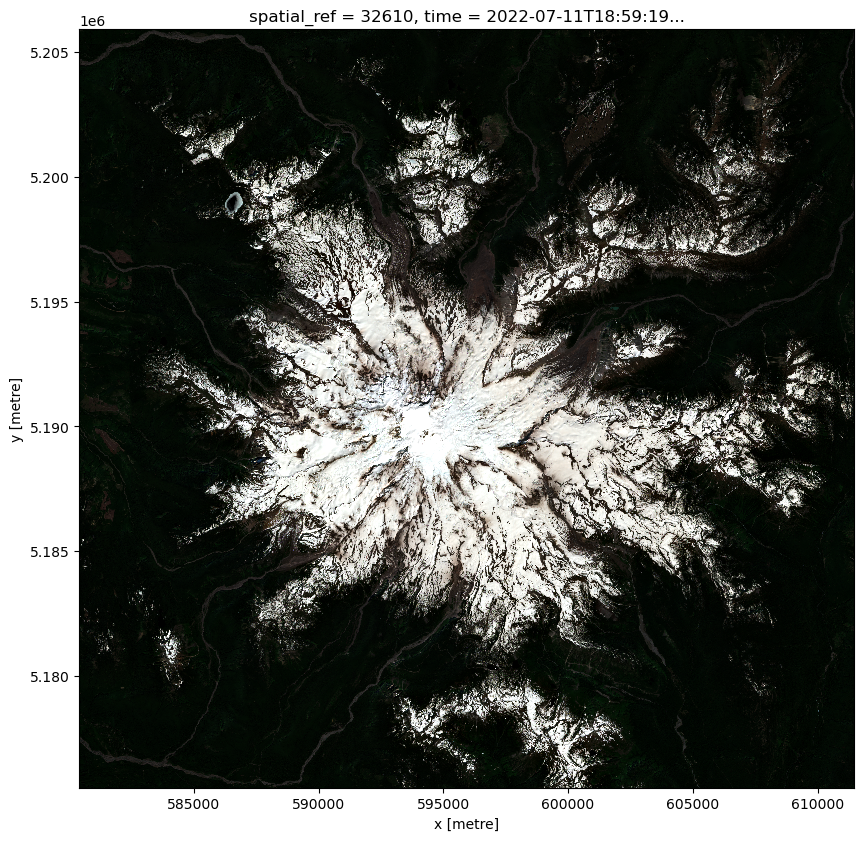

In [22]:
f,ax=plt.subplots(figsize=(10,10))
s2.rgb.squeeze().squeeze().plot.imshow(robust=True)
ax.set_aspect('equal')
# remove squeeze after next easysnowdata update

In [24]:
modis = easysnowdata.remote_sensing.MODIS_snow(bbox_gdf,clip_to_bbox=False,start_date='2014-10-02',end_date='2023-09-30',data_product="MOD10A2", bands='Maximum_Snow_Extent').data['Maximum_Snow_Extent']

ValueError: The truth value of a GeoDataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
modis

In [ ]:
modis.coords['WY'] = ("time",pd.to_datetime(modis.time).map(easysnowdata.utils.datetime_to_WY))
modis.coords['DOWY'] = ("time",pd.to_datetime(modis.time).map(easysnowdata.utils.datetime_to_DOWY))

In [ ]:
modis

In [ ]:
modis[modis['WY']==2023].rio.reproject_match(s2.data).plot.imshow(col='time',col_wrap=8)

In [ ]:
def mod10a2_seasonal_snow_mask(da):

    SNOW_VALUE = 200
    CLOUD_VALUE = 50
    NO_SNOW_VALUE = 25

    def mod10a2_wrzesien_cloud_filling(da, SNOW_VALUE=SNOW_VALUE, CLOUD_VALUE=CLOUD_VALUE, NO_SNOW_VALUE=NO_SNOW_VALUE):
        # My implementation of Wrzesien et al. 2019's cloud filling approach... "To allow for cloudy conditions during periods of snow accumulation, we assume that if two snow-covered MOD10A2 observations bracket one or more cloudy MOD10A2 observations, the cloudy period is likely snow covered, too. Following this assumption, we require only the first and last 8-day MOD10A2 observations to be snow covered. That is to say, if we have one snowy MOD10A2 observation, five cloudy MOD10A2 periods, and one snowy observation, we classify the 56-day period as snow covered."
        # this should return binary (0:nosnow, 1:snow), where 1 can be either snow or cloud(s) bracketed by snow
        effective_snow = xr.where((da.where(lambda x: x!=CLOUD_VALUE).ffill(dim='time') == SNOW_VALUE) & (da.where(lambda x: x!=CLOUD_VALUE).bfill(dim='time') == SNOW_VALUE),1,0)
        
        return effective_snow

    effective_snow = mod10a2_wrzesien_cloud_filling(da)

    # Now use this effective_snow to count consecutive snow days
    def get_longest_consec_stretch(arr):
        max_len = 0
        max_start = 0
        max_end = 0
        current_start = None
        for i, val in enumerate(arr):
            if val:
                if current_start is None:
                    current_start = i
            else:
                if current_start is not None:
                    length = i - current_start
                    if length > max_len:
                        max_len = length
                        max_start = current_start
                        max_end = i - 1
                    current_start = None
        if current_start is not None:
            length = len(arr) - current_start
            if length > max_len:
                max_len = length
                max_start = current_start
                max_end = len(arr) - 1
        return max_start, max_end, max_len
    
    # Apply function along the time dimension using the effective snow data
    results = xr.apply_ufunc(
        get_longest_consec_stretch, 
        effective_snow,
        input_core_dims=[['time']],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int, int, int]
    )

    substitution_dict = {index: value for index, value in enumerate(da.DOWY.values)}

    def map_values(value):
        return np.vectorize(substitution_dict.get)(value)

    snow_start_DOWY = xr.apply_ufunc(
        map_values,
        results[0],
        vectorize=True,  # This allows for the function to apply element-wise
        dask='parallelized'
    )
    snow_end_DOWY = xr.apply_ufunc(
        map_values,
        results[1],
        vectorize=True,  # This allows for the function to apply element-wise
        dask='parallelized'
    )
    
    snow_mask = xr.Dataset({
        'SAD_DOWY': snow_start_DOWY.astype(np.int16),
        'SDD_DOWY': snow_end_DOWY.astype(np.int16)+8,
        'max_consec_snow_days': results[2].astype(np.int16)*8
    })

    return snow_mask

In [ ]:
modis_mask = modis.chunk(dict(time=-1)).groupby('WY').apply(mod10a2_seasonal_snow_mask).compute()

In [ ]:
modis_mask

In [ ]:
f,ax=plt.subplots(1,3,figsize=(12,4))
modis_mask['SAD_DOWY'].sel(WY=2023).plot(ax=ax[0])
modis_mask['SDD_DOWY'].sel(WY=2023).plot(ax=ax[1])
modis_mask['max_consec_snow_days'].sel(WY=2023).plot(ax=ax[2])

In [ ]:
modis_mask.nbytes/1E9

In [ ]:
modis_mask.sel(WY=2023)['max_consec_snow_days'].where(lambda x: x>=56).plot()

In [ ]:
modis_grid = gpd.read_file('zip+http://book.ecosens.org/wp-content/uploads/2016/06/modis_grid.zip!modis_sinusoidal_grid_world.shp')
land = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land_modis_crs = gpd.GeoSeries(land.unary_union,crs='EPSG:4326').to_crs(modis_grid.crs)
modis_grid_land_idx = modis_grid.intersects(land_modis_crs.unary_union)
modis_grid_land = modis_grid[modis_grid_land_idx]
modis_grid_not_land = modis_grid[~modis_grid_land_idx]

In [ ]:
f,ax=plt.subplots(figsize=(15,15))
land_modis_crs.plot(ax=ax,color='green')
modis_grid_not_land.geometry.boundary.plot(ax=ax,color='gray',linewidth=0.5)
modis_grid_land.geometry.boundary.plot(ax=ax,color='blue',linewidth=2)

In [ ]:
modis_grid_land

In [ ]:
import pystac_client
import planetary_computer
product= "MOD10A2"
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
search = catalog.search(
    collections=[f"modis-{product[3:]}-061"],
    bbox=bbox_gdf.total_bounds,
    datetime=('2020-01-01', '2020-01-01'),
    
)

In [ ]:
search.get_all_items()

In [ ]:

search = catalog.search(
    collections=[f"modis-{product[3:]}-061"],
    bbox=bbox_gdf.total_bounds,
    datetime=('2020-01-01', '2020-01-01'),
    query={
        "modis:vertical-tile": {"eq": your_desired_vertical_value},
        "modis:horizontal-tile": {"eq": your_desired_horizontal_value}
    }    
)

search.get_all_items()